In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score as r2
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             accuracy_score, classification_report, plot_confusion_matrix,
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

Задача
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Целевая переменная
Credit Default - факт невыполнения кредитных обязательств

Метрика качества
F1-score (sklearn.metrics.f1_score)

Целевая метрика
F1 > 0.5 Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

Значения полей датасета:
Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)

Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)

Monthly Debt - ежемесячный долг

Credit Score - баллы кредитного рейтинга

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Загрузка датасета


In [7]:
TRAIN_DATASET_PATH = '../input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '../input/gb-credit-default/test.csv'
SAMPLE_SUBMIT_PATH = '../input/gb-credit-default/sample_submission.csv'

In [8]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df.shape

(7500, 17)

In [10]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [12]:
test_df.shape

(2500, 16)

Обзор 
датасета

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [14]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [16]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

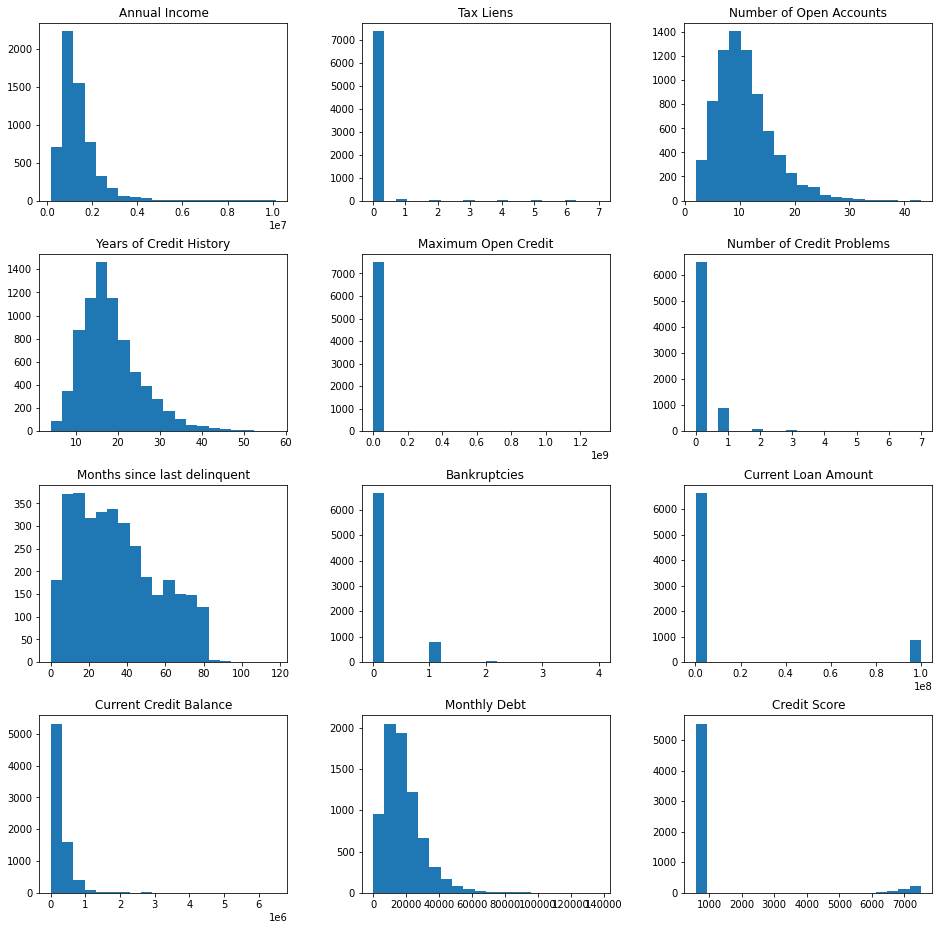

In [17]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

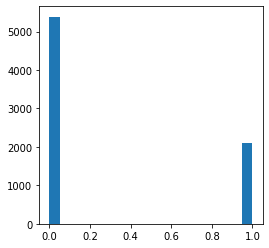

In [18]:
df[TARGET_NAME].hist(figsize=(4, 4), bins=20, grid=False);

In [19]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

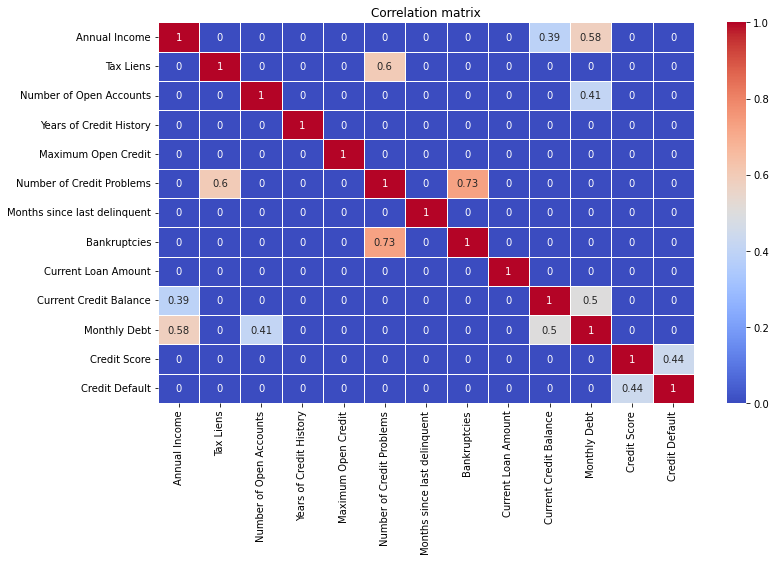

In [20]:
plt.figure(figsize=(12, 7))

# sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


Обработка категориальных признаков

Home Ownership и Purpose преведем в цифру вероятности возврата кредита, Years in current job переведем в численные значения, Term сделаем бинарным.

In [21]:
df_cat = df.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Home_Ownership'
})
df_cat = pd.DataFrame(df_cat)

df = df.merge(df_cat, on='Home Ownership', how='left')
test_df = test_df.merge(df_cat, on='Home Ownership', how='left')
df['Years in current job'] = df['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})

test_df['Years in current job'] = test_df['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
df_cat = df.groupby('Purpose', as_index=False).mean()[['Purpose', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Purpose'
})
df_cat = pd.DataFrame(df_cat)
df = df.merge(df_cat, on='Purpose', how='left')
test_df = test_df.merge(df_cat, on='Purpose', how='left')

df['Term'] = df['Term'].map({'Long Term':'1', 'Short Term':'2'}).astype(int)
test_df['Term'] = test_df['Term'].map({'Long Term':'1', 'Short Term':'2'}).astype(int)

Новый признак.

Создадим категории для Monthly Debt и сделаем признак вероятности возврата кредита по этим категориям.

In [22]:
Monthly_Debt_max = df['Monthly Debt'].max()

def Monthly_Debt_cat(X):
    bins = [0, 10067.50, 16076.50, 23818.00, Monthly_Debt_max]
    X['Monthly_Debt_cat'] = pd.cut(X['Monthly Debt'], bins=bins, labels=False)
    
    X['Monthly_Debt_cat'].fillna(-1, inplace=True)
    return X

In [23]:
df = Monthly_Debt_cat(df)
test_df = Monthly_Debt_cat(test_df)

df_cat = df.groupby('Monthly_Debt_cat', as_index=False).mean()[['Monthly_Debt_cat', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Monthly_Debt_cat'
})
df_cat = pd.DataFrame(df_cat)

df = df.merge(df_cat, on='Monthly_Debt_cat', how='left')
test_df = test_df.merge(df_cat, on='Monthly_Debt_cat', how='left')

Обработка пропусков

Пропуски в Annual Income, Months since last delinquent, Bankruptcies заменим медианами, Years in current job модой.




In [24]:
df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].median()
test_df.loc[test_df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].median()

df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].median()
test_df.loc[test_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].median()

df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].median()
test_df.loc[test_df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].median()

df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]
test_df.loc[test_df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]

Пропуски в Credit Score обработаем позже.

Обработка выбросов

Сравнение по каждому признаку медианы и среднего значения (mean). Разница значений между которыми говорит о возможных выбросах в данных: Maximum Open Credit, Current Loan Amount и Credit Score.



Максимальный кредит - 99999999.0 Выбросы в Maximum Open Credit и Current Loan Amount заменим медианой.

In [25]:
df.loc[df['Maximum Open Credit'] > 99999999.0, 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df['Current Loan Amount'].median()
test_df.loc[test_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df['Current Loan Amount'].median()

Credit Score

Значение больше 1000 - выброс, заменим на Nan

In [26]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Credit Score'
df = preprocess_outlier(df, feature_name, threshold=1000)
df_test = preprocess_outlier(test_df, feature_name, threshold=1000)

df[feature_name].isna().sum()

1957

In [27]:
df_copy = df.copy()
df_test_copy = test_df.copy()

In [28]:
feature_name = 'Credit Score'
df_copy[feature_name].isna().sum()

1957

Уберем ненужные признаки.

In [29]:
df_copy = df_copy.drop(columns=['Home Ownership','Purpose','Credit Default'])
df_test_copy = df_test_copy.drop(columns=['Home Ownership','Purpose'])

Для обучения и предсказания применим RandomForestRegressor

In [30]:
def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=10,
                                  max_depth=5,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
     
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [31]:
score_predictor, df_copy = imputer_rfr(df_copy, feature_name)

r2 на train: 0.3826422840151542
r2 на test: 0.2277790533212508


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


К сожалению, добиться результата лучше не удалось. Заполняем пропуски.

In [32]:
predict_data = df_test_copy[df_test_copy[feature_name].isna()]
pred = score_predictor.predict(predict_data.drop(columns=feature_name))
df_test_copy.loc[df_test_copy[feature_name].isna(), feature_name] = list(pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [33]:
df_copy[feature_name].isna().sum()

0

Отбор признаков.

In [34]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

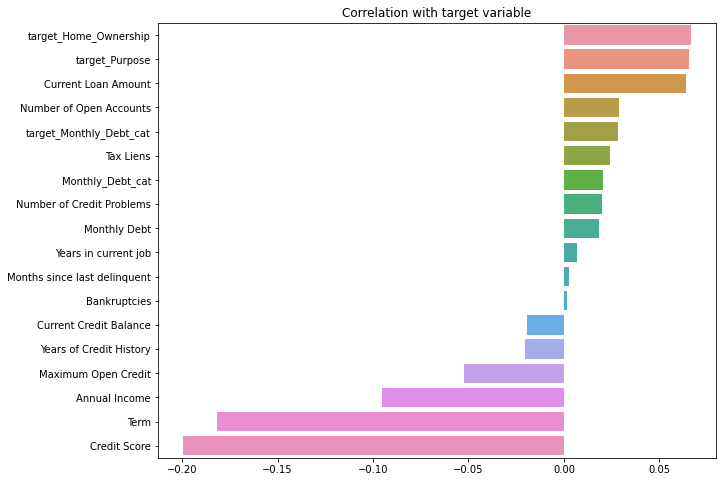

In [35]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [36]:
FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'target_Home_Ownership', 'target_Purpose',
      'target_Monthly_Debt_cat','Monthly_Debt_cat']

In [37]:
X = df_copy[FEATURE_NAMES]
y = df['Credit Default']

Разделение трейн и тест

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.33, 
                                                      shuffle=True, 
                                                      random_state=42, 
                                                      stratify=y)
display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718209
1    0.281791
Name: Credit Default, dtype: float64

0    0.718384
1    0.281616
Name: Credit Default, dtype: float64

Дисбаланс

In [39]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5487288135593222

LGBMClassifier

In [40]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:2.55},
                                 n_estimators=60,
                                 max_depth=3,
                                 reg_lambda=1.9
                                )
model_lgbm.fit(X_train, y_train)
THRESHOLD = 0.6
evaluate_preds(model_lgbm, X_train,X_valid, y_train, y_valid)


TRAIN
 0.573
TEST
 0.525
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.60      0.72      3609
           1       0.44      0.81      0.57      1416

    accuracy                           0.66      5025
   macro avg       0.67      0.71      0.65      5025
weighted avg       0.76      0.66      0.68      5025

VALID

              precision    recall  f1-score   support

           0       0.85      0.57      0.68      1778
           1       0.41      0.75      0.53       697

    accuracy                           0.62      2475
   macro avg       0.63      0.66      0.60      2475
weighted avg       0.73      0.62      0.64      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1015  763
1                177  520
CPU times: user 376 ms, sys: 7.11 ms, total: 383 ms
Wall time: 151 ms


Сохранение модели

In [41]:
df_test_copy.shape

(2500, 18)

In [42]:
submit = pd.read_csv(SAMPLE_SUBMIT_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [43]:
predictions = model_lgbm.predict(df_test_copy)

In [44]:
predictions

array([1, 1, 1, ..., 1, 0, 1])

In [45]:
submit['Credit Default'] = predictions

In [46]:
submit.to_csv('ntebookb53a8a8448.csv', index=False)